In [19]:
import aiohttp
import asyncio
import nest_asyncio
import base64
import os
import requests
import time
import matplotlib.pyplot as plt

# Apply nest_asyncio to allow nested event loops in Jupyter Notebook
nest_asyncio.apply()




In [20]:

# Define the maximum size of each chunk in bytes (1 MB in this case)
MAX_CHUNK_SIZE = 512 * 1024-200

def list_connections(admin_url):
    try:
        response = requests.get(f'{admin_url}/connections')
        response.raise_for_status()
        connections = response.json()
        print("Connections:", connections)
        return connections
    except requests.RequestException as e:
        print(f"Failed to list connections: {e}")
        return None

def read_and_encode_file(file_path):
    try:
        with open(file_path, 'rb') as file:
            file_content = file.read()
        encoded_content = base64.b64encode(file_content).decode('utf-8')
        return encoded_content
    except Exception as e:
        print(f"Failed to read and encode file {file_path}: {e}")
        return None

def split_into_chunks(encoded_content, chunk_size):
    return [encoded_content[i:i + chunk_size] for i in range(0, len(encoded_content), chunk_size)]

async def send_didcomm_message(admin_url, conn_id, message, latency_list, timestamps, start_time):
    async with aiohttp.ClientSession() as session:
        try:
            url = f'{admin_url}/connections/{conn_id}/send-message'
            payload = message
            request_time = time.time()
            async with session.post(url, json=payload) as response:
                response_time = time.time()
                latency = response_time - request_time
                latency_list.append(latency)
                elapsed_time = response_time - start_time
                timestamps.append(elapsed_time)
                if response.status == 200:
                    result = await response.json()
                    print("Message sent successfully:")
                    print(result)
                else:
                    print(f"Failed to send message: {response.status}")
                    print(await response.text())
        except aiohttp.ClientError as e:
            print(f"Failed to send message: {e}")

async def testPerformance(admin_url, data_folder, num_repeats, latency_list, throughput_list, timestamps):
    connections = list_connections(admin_url)
    if not connections:
        return

    if 'results' in connections and len(connections['results']) > 0:
        conn_id = connections['results'][0]['connection_id']
    else:
        print("No connections found.")
        return

    if not os.path.isdir(data_folder):
        print(f"Data folder '{data_folder}' does not exist.")
        return

    encoded_files = []
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)
        if os.path.isfile(file_path):
            encoded_content = read_and_encode_file(file_path)
            if encoded_content:
                encoded_files.append((file_name, encoded_content))

    if not encoded_files:
        print("No files to encode and send.")
        return

    didcomm_message_template = {
        "type": "https://didcomm.org/file-transfer/1.0/message",
        "attachments": []
    }

    start_time = time.time()

    for _ in range(num_repeats):
        for file_name, encoded_content in encoded_files:
            chunks = split_into_chunks(encoded_content, MAX_CHUNK_SIZE)
            for idx, chunk in enumerate(chunks):
                didcomm_message = didcomm_message_template.copy()
                didcomm_message["attachments"] = [
                    {
                        "filename": f"{file_name}.part{idx + 1}",
                        "data": {
                            "base64": chunk
                        }
                    }
                ]
                didcomm_message["content"] = f"Sending file {file_name} part {idx + 1}"
                await send_didcomm_message(admin_url, conn_id, didcomm_message, latency_list, timestamps, start_time)
                if latency_list[-1] != 0:
                    throughput_list.append(len(chunk) / latency_list[-1])
                else:
                    throughput_list.append(0)



def plot_metrics(latency_list, throughput_list, timestamps, data_folder):
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Latency (s)', color='tab:blue')
    ax1.plot(timestamps, latency_list, color='tab:blue', label='Latency')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Throughput (bytes/s)', color='tab:orange')
    ax2.plot(timestamps, throughput_list, color='tab:orange', label='Throughput')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    fig.tight_layout()
    plt.title(f'Performance Metrics for {data_folder}')
    plt.legend(loc='upper left')
    plt.show()




Connections: {'results': [{'state': 'active', 'created_at': '2024-06-05T10:47:59.640314Z', 'updated_at': '2024-06-05T10:47:59.865380Z', 'connection_id': '4f565f80-6d77-478e-9af6-aa8f51ad16e1', 'my_did': 'did:peer:4zQmd1vacj1aD2HUjy2jqPrKXr2r7HQ1XpGZ9HsMLwy3tZR2', 'their_did': 'did:peer:4zQmabxaLu7SkEJQtZ6JXpvHhJ2a6eh72y1hbZEew6AhbiRc', 'their_label': 'faber.agent', 'their_role': 'inviter', 'connection_protocol': 'didexchange/1.1', 'rfc23_state': 'completed', 'invitation_key': 'FR5W3cPCTC7Gcx76mqJBNUNXVsjSn8La4MXxKwLVtGS5', 'invitation_msg_id': '8442e357-6560-42ec-9e32-e7b3a5704ad4', 'request_id': 'de3ec28e-16ee-4a47-b25e-f81df70e12ad', 'accept': 'auto', 'invitation_mode': 'once'}]}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}


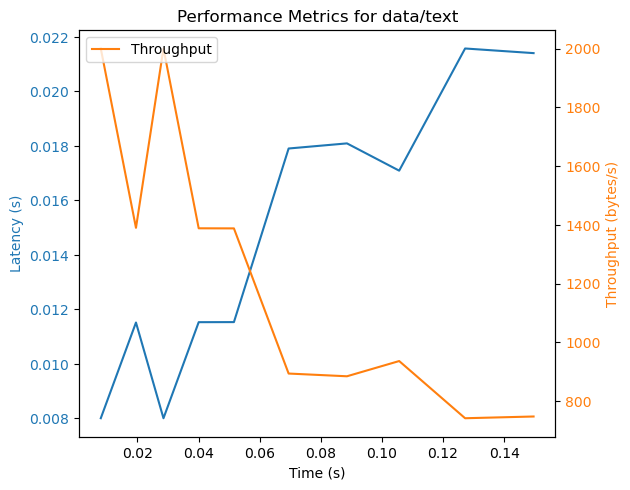

Connections: {'results': [{'state': 'active', 'created_at': '2024-06-05T10:47:59.640314Z', 'updated_at': '2024-06-05T10:47:59.865380Z', 'connection_id': '4f565f80-6d77-478e-9af6-aa8f51ad16e1', 'my_did': 'did:peer:4zQmd1vacj1aD2HUjy2jqPrKXr2r7HQ1XpGZ9HsMLwy3tZR2', 'their_did': 'did:peer:4zQmabxaLu7SkEJQtZ6JXpvHhJ2a6eh72y1hbZEew6AhbiRc', 'their_label': 'faber.agent', 'their_role': 'inviter', 'connection_protocol': 'didexchange/1.1', 'rfc23_state': 'completed', 'invitation_key': 'FR5W3cPCTC7Gcx76mqJBNUNXVsjSn8La4MXxKwLVtGS5', 'invitation_msg_id': '8442e357-6560-42ec-9e32-e7b3a5704ad4', 'request_id': 'de3ec28e-16ee-4a47-b25e-f81df70e12ad', 'accept': 'auto', 'invitation_mode': 'once'}]}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}


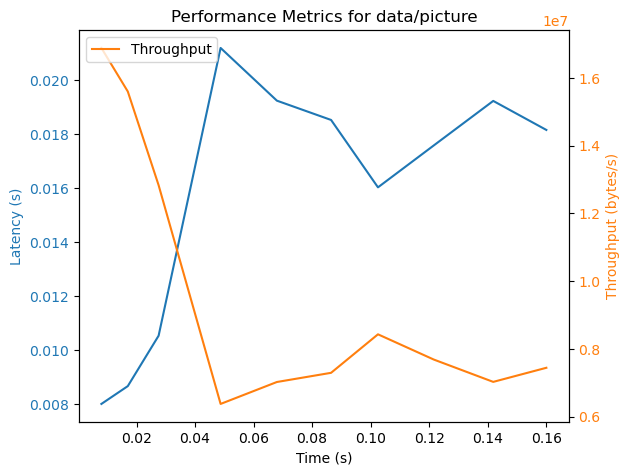

Connections: {'results': [{'state': 'active', 'created_at': '2024-06-05T10:47:59.640314Z', 'updated_at': '2024-06-05T10:47:59.865380Z', 'connection_id': '4f565f80-6d77-478e-9af6-aa8f51ad16e1', 'my_did': 'did:peer:4zQmd1vacj1aD2HUjy2jqPrKXr2r7HQ1XpGZ9HsMLwy3tZR2', 'their_did': 'did:peer:4zQmabxaLu7SkEJQtZ6JXpvHhJ2a6eh72y1hbZEew6AhbiRc', 'their_label': 'faber.agent', 'their_role': 'inviter', 'connection_protocol': 'didexchange/1.1', 'rfc23_state': 'completed', 'invitation_key': 'FR5W3cPCTC7Gcx76mqJBNUNXVsjSn8La4MXxKwLVtGS5', 'invitation_msg_id': '8442e357-6560-42ec-9e32-e7b3a5704ad4', 'request_id': 'de3ec28e-16ee-4a47-b25e-f81df70e12ad', 'accept': 'auto', 'invitation_mode': 'once'}]}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message sent successfully:
{}
Message s

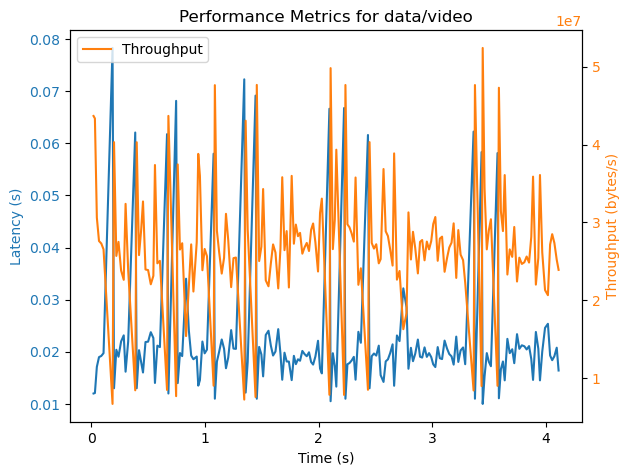

In [21]:
async def main():
    test_cases = [
        ('http://localhost:8031', 'data/text', 10),
        ('http://localhost:8031', 'data/picture', 10),
        ('http://localhost:8031', 'data/video', 5),
    ]

    for admin_url, data_folder, num_repeats in test_cases:
        latency_list = []
        throughput_list = []
        timestamps = []
        await testPerformance(admin_url, data_folder, num_repeats, latency_list, throughput_list, timestamps)
        plot_metrics(latency_list, throughput_list, timestamps, data_folder)

# Run the main function
asyncio.run(main())